# Introduction: Popularity Estimation of a Song on Spotify

The "spotify"  dataset contains 114000 Spotify tracks over a range of 125 different genres, collected  using Spotify's Web API in 2023.

Each track has many features associated to it, containing identifying, objective and subjective characteristics.

The goal here is to predict, as a multi-class classification task, the popularity of a song in Spotify, ranging it as low, medium or high.

Source : https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset

## Column Description

### Identifying

- track_id: The Spotify ID for the track

- artists: The artists' names who performed the track

- album_name: The album name in which the track appears

- track_name: Name of the track

- track_genre: The genre in which the track belongs

### Objective

duration_ms, explicit, key, loudness, mode, speechiness, instrumentalness, liveness, tempo, time_signature.

### Subjective

- popularity (TARGET): The popularity of a track is a value based on the total number of plays the track has had. 

- danceability: Describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity.

- energy: Represents a perceptual measure of intensity and activity. 

- acousticness: A confidence measure of whether the track is acoustic. 

- valence: Describes the musical positiveness conveyed by a track.

# Preliminary Inspection

## Importing Modules

In [1]:
!pip install imblearn==0.0


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install missingno==0.5.2


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import missingno as msno
import warnings
warnings.filterwarnings('ignore')

from sklearn.svm import SVC
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from scipy.stats import loguniform, uniform
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline as IMBPipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder, KBinsDiscretizer, FunctionTransformer, label_binarize
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, RepeatedStratifiedKFold, RandomizedSearchCV, learning_curve, validation_curve

## Data Loading

In [4]:
dataset = pd.read_csv('songs.csv')

In [5]:
dataset

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113995,113995,2C3TZjDRiAzdyViavDJ217,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Sleep My Little Boy,21,384999,False,0.172,0.2350,...,-16.393,1,0.0422,0.6400,0.928000,0.0863,0.0339,125.995,5,world-music
113996,113996,1hIz5L4IB9hN3WRYPOCGPw,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Water Into Light,22,385000,False,0.174,0.1170,...,-18.318,0,0.0401,0.9940,0.976000,0.1050,0.0350,85.239,4,world-music
113997,113997,6x8ZfSoqDjuNa5SVP5QjvX,Cesária Evora,Best Of,Miss Perfumado,22,271466,False,0.629,0.3290,...,-10.895,0,0.0420,0.8670,0.000000,0.0839,0.7430,132.378,4,world-music
113998,113998,2e6sXL2bYv4bSz6VTdnfLs,Michael W. Smith,Change Your World,Friends,41,283893,False,0.587,0.5060,...,-10.889,1,0.0297,0.3810,0.000000,0.2700,0.4130,135.960,4,world-music


In [6]:
dataset['track_genre'].unique()

array(['acoustic', 'afrobeat', 'alt-rock', 'alternative', 'ambient',
       'anime', 'black-metal', 'bluegrass', 'blues', 'brazil',
       'breakbeat', 'british', 'cantopop', 'chicago-house', 'children',
       'chill', 'classical', 'club', 'comedy', 'country', 'dance',
       'dancehall', 'death-metal', 'deep-house', 'detroit-techno',
       'disco', 'disney', 'drum-and-bass', 'dub', 'dubstep', 'edm',
       'electro', 'electronic', 'emo', 'folk', 'forro', 'french', 'funk',
       'garage', 'german', 'gospel', 'goth', 'grindcore', 'groove',
       'grunge', 'guitar', 'happy', 'hard-rock', 'hardcore', 'hardstyle',
       'heavy-metal', 'hip-hop', 'honky-tonk', 'house', 'idm', 'indian',
       'indie-pop', 'indie', 'industrial', 'iranian', 'j-dance', 'j-idol',
       'j-pop', 'j-rock', 'jazz', 'k-pop', 'kids', 'latin', 'latino',
       'malay', 'mandopop', 'metal', 'metalcore', 'minimal-techno', 'mpb',
       'new-age', 'opera', 'pagode', 'party', 'piano', 'pop-film', 'pop',
       'pow

In [7]:
dataset['track_genre'].value_counts()

track_genre
world-music          1000
acoustic             1000
show-tunes           1000
singer-songwriter    1000
ska                  1000
                     ... 
anime                1000
black-metal          1000
bluegrass            1000
blues                1000
brazil               1000
Name: count, Length: 114, dtype: int64

## Initial Feature Extraction and Selection

To reduce computational complexity and have a more precise goal, I decided to focus on 5 music genres, which, according to the most relevant newspapers, reflect current trends and musical preferences of Italians in 2024: pop, rock, hip-hop, dance and singer-songwriter.

In [8]:
track_genre_selected = ['pop', 'rock', 'hip-hop', 'dance', 'singer-songwriter']
dataset.drop(index=dataset[~dataset['track_genre'].isin(track_genre_selected)].index, inplace=True)

In [9]:
dataset['track_genre'].unique()

array(['dance', 'hip-hop', 'pop', 'rock', 'singer-songwriter'],
      dtype=object)

In [10]:
dataset

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
20000,20000,5IgjP7X4th6nMNDh4akUHb,Chris Brown,Indigo (Extended),Under The Influence,96,184613,True,0.733,0.690,...,-5.529,0,0.0427,0.06350,0.000001,0.1050,0.310,116.992,4,dance
20001,20001,3nqQXoyQOWXiESFLlDF1hG,Sam Smith;Kim Petras,Unholy (feat. Kim Petras),Unholy (feat. Kim Petras),100,156943,False,0.714,0.472,...,-7.375,1,0.0864,0.01300,0.000005,0.2660,0.238,131.121,4,dance
20002,20002,5nCthAh3jt4xKuLJAifAaR,Katy Perry,Harleys In Hawaii,Harleys In Hawaii,73,185815,False,0.722,0.757,...,-6.207,0,0.1320,0.18500,0.000006,0.1260,0.721,140.094,4,dance
20003,20003,48QmG1dfvMuYLxMPt7KSRA,Sean Paul;Dua Lipa,Mad Love The Prequel,No Lie,83,221176,False,0.742,0.882,...,-2.862,1,0.1170,0.04660,0.000000,0.2060,0.463,102.040,4,dance
20004,20004,7BKLCZ1jbUBVqRi2FVlTVw,The Chainsmokers;Halsey,Closer,Closer,84,244960,False,0.748,0.524,...,-5.599,1,0.0338,0.41400,0.000000,0.1110,0.661,95.010,4,dance
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,171luCSfSTBnaIVnfTVbS6,Melike Şahin,Merhem: İlk Konserler (Live),Nasır (Live @ Zorlu PSM),42,269354,False,0.551,0.478,...,-10.580,0,0.0378,0.52600,0.000000,0.2880,0.523,98.056,4,singer-songwriter
99996,99996,4nGy2XA9QGxYb90cNyHguO,Barış Kocatürk,Kesin Kesiktir,Kalmalısın,42,199285,False,0.646,0.645,...,-6.775,0,0.0287,0.24600,0.000000,0.1810,0.687,121.999,4,singer-songwriter
99997,99997,3i0VfLdOUCks9DmAht65XI,Nina Nesbitt,"The Sun Will Come up, The Seasons Will Change",The Best You Had,60,176853,True,0.690,0.582,...,-6.259,0,0.0333,0.35800,0.000000,0.0776,0.448,122.020,4,singer-songwriter
99998,99998,4ggwK5lXtlTT7lKJeeEnxf,Joe Walsh,(70's) Seventies Collected Volume 2,Rocky Mountain Way,0,316066,False,0.449,0.571,...,-7.119,1,0.0492,0.00604,0.701000,0.0748,0.448,84.807,4,singer-songwriter


Now, I want to delete the columns "Unnamed: 0" which is practically the number of the row and doesn't add any information to the data, "track_id" and 'track_name', as they only give either the identification code or the name (which are different and highly specific for each song). 

In [11]:
# I delete the subset of columns
dataset.drop(columns=['Unnamed: 0', 'track_id', 'track_name'], inplace=True)  

## Data Visualization

### Correlation Matrix

Here, I construct the correlation matrix to better understand the relationships between each feature. Despite this, it is important to highlight that correlation alone is not enough for a proper analysis and, therefore, a more precise feature importance analysis is needed to be fully conscious of the contributions of the different variables.

Firstly, let's analyze the data types in order to appropriately address the categorical features.

In [12]:
print(dataset.dtypes)

artists              object
album_name           object
popularity            int64
duration_ms           int64
explicit               bool
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
track_genre          object
dtype: object


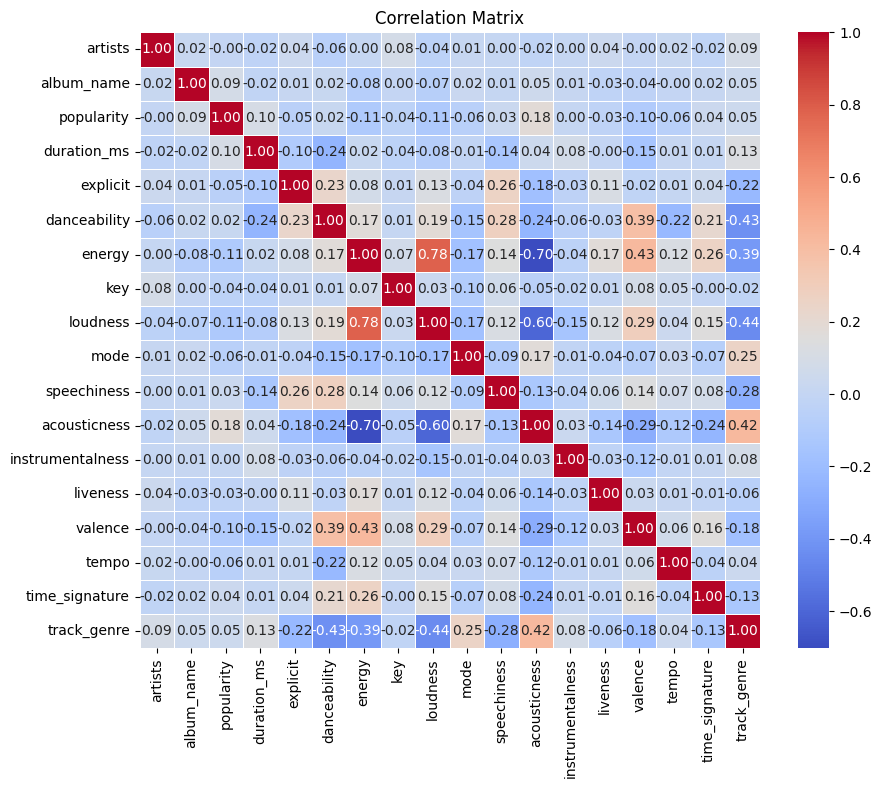

In [13]:
# I create a copy of the dataset in order to not modify the original
dataset_copy = dataset.copy()

label_encoder = LabelEncoder()

# Encode categorical columns
categorical_columns = ['artists', 'album_name', 'track_genre']  

for col in categorical_columns:
    dataset_copy[col] = label_encoder.fit_transform(dataset_copy[col])

# Compute correlation matrix
corr_matrix = dataset_copy.corr()

plt.figure(figsize=(10, 8))  
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

### Target Feature

In order to be able to predict the target 'popularity' and guarantee an equal distribution among train and test sets (there's the possibility that the less populated class of the target contains only one observation), I do need to group its values into bins.

Before doing it, let's have a look at the distribution of the feature target.

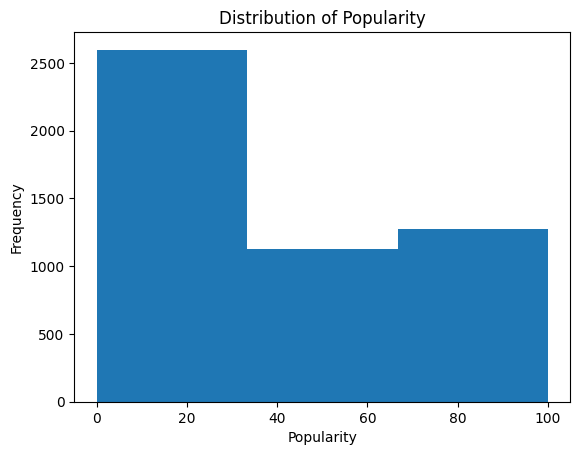

In [14]:
plt.hist(dataset['popularity'].values, bins=3)
plt.title('Distribution of Popularity')
plt.xlabel('Popularity')
plt.ylabel('Frequency')
plt.show()

Let's now proceed with binning:

In [15]:
kbins = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')  # 5 bins uniformly distributed
dataset['popularity_binned'] = kbins.fit_transform(dataset['popularity'].values.reshape(-1, 1)).ravel()

In [16]:
dataset['popularity_binned'].value_counts()

popularity_binned
0.0    2597
2.0    1275
1.0    1128
Name: count, dtype: int64

A new column 'popularity_binned' has been added to the dataset:

In [17]:
dataset

,artists,album_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,popularity_binned
20000,Chris Brown,Indigo (Extended),96,184613,True,0.733,0.690,9,-5.529,0,0.0427,0.06350,0.000001,0.1050,0.310,116.992,4,dance,2.0
20001,Sam Smith;Kim Petras,Unholy (feat. Kim Petras),100,156943,False,0.714,0.472,2,-7.375,1,0.0864,0.01300,0.000005,0.2660,0.238,131.121,4,dance,2.0
20002,Katy Perry,Harleys In Hawaii,73,185815,False,0.722,0.757,10,-6.207,0,0.1320,0.18500,0.000006,0.1260,0.721,140.094,4,dance,2.0
20003,Sean Paul;Dua Lipa,Mad Love The Prequel,83,221176,False,0.742,0.882,7,-2.862,1,0.1170,0.04660,0.000000,0.2060,0.463,102.040,4,dance,2.0
20004,The Chainsmokers;Halsey,Closer,84,244960,False,0.748,0.524,8,-5.599,1,0.0338,0.41400,0.000000,0.1110,0.661,95.010,4,dance,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,Melike Şahin,Merhem: İlk Konserler (Live),42,269354,False,0.551,0.478,10,-10.580,0,0.0378,0.52600,0.000000,0.2880,0.523,98.056,4,singer-songwriter,1.0
99996,Barış Kocatürk,Kesin Kesiktir,42,199285,False,0.646,0.645,11,-6.775,0,0.0287,0.24600,0.000000,0.1810,0.687,121.999,4,singer-songwriter,1.0
99997,Nina Nesbitt,"The Sun Will Come up, The Seasons Will Change",60,176853,True,0.690,0.582,5,-6.259,0,0.0333,0.35800,0.000000,0.0776,0.448,122.020,4,singer-songwriter,1.0
99998,Joe Walsh,(70's) Seventies Collected Volume 2,0,316066,False,0.449,0.571,4,-7.119,1,0.0492,0.00604,0.701000,0.0748,0.448,84.807,4,singer-songwriter,0.0


 Now, the column 'popularity' is no longer useful to reach my goal, so I drop it and keep just the new one.

In [18]:
dataset.drop(columns=['popularity'], inplace=True) 

## Handling Missing Values

First, I need to check the presence of missing values:

In [19]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 20000 to 99999
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   artists            5000 non-null   object 
 1   album_name         5000 non-null   object 
 2   duration_ms        5000 non-null   int64  
 3   explicit           5000 non-null   bool   
 4   danceability       5000 non-null   float64
 5   energy             5000 non-null   float64
 6   key                5000 non-null   int64  
 7   loudness           5000 non-null   float64
 8   mode               5000 non-null   int64  
 9   speechiness        5000 non-null   float64
 10  acousticness       5000 non-null   float64
 11  instrumentalness   5000 non-null   float64
 12  liveness           5000 non-null   float64
 13  valence            5000 non-null   float64
 14  tempo              5000 non-null   float64
 15  time_signature     5000 non-null   int64  
 16  track_genre        5000 

To visualize better the situation, let's use the msno method, which illustrates all features in a matrix:

<AxesSubplot: >

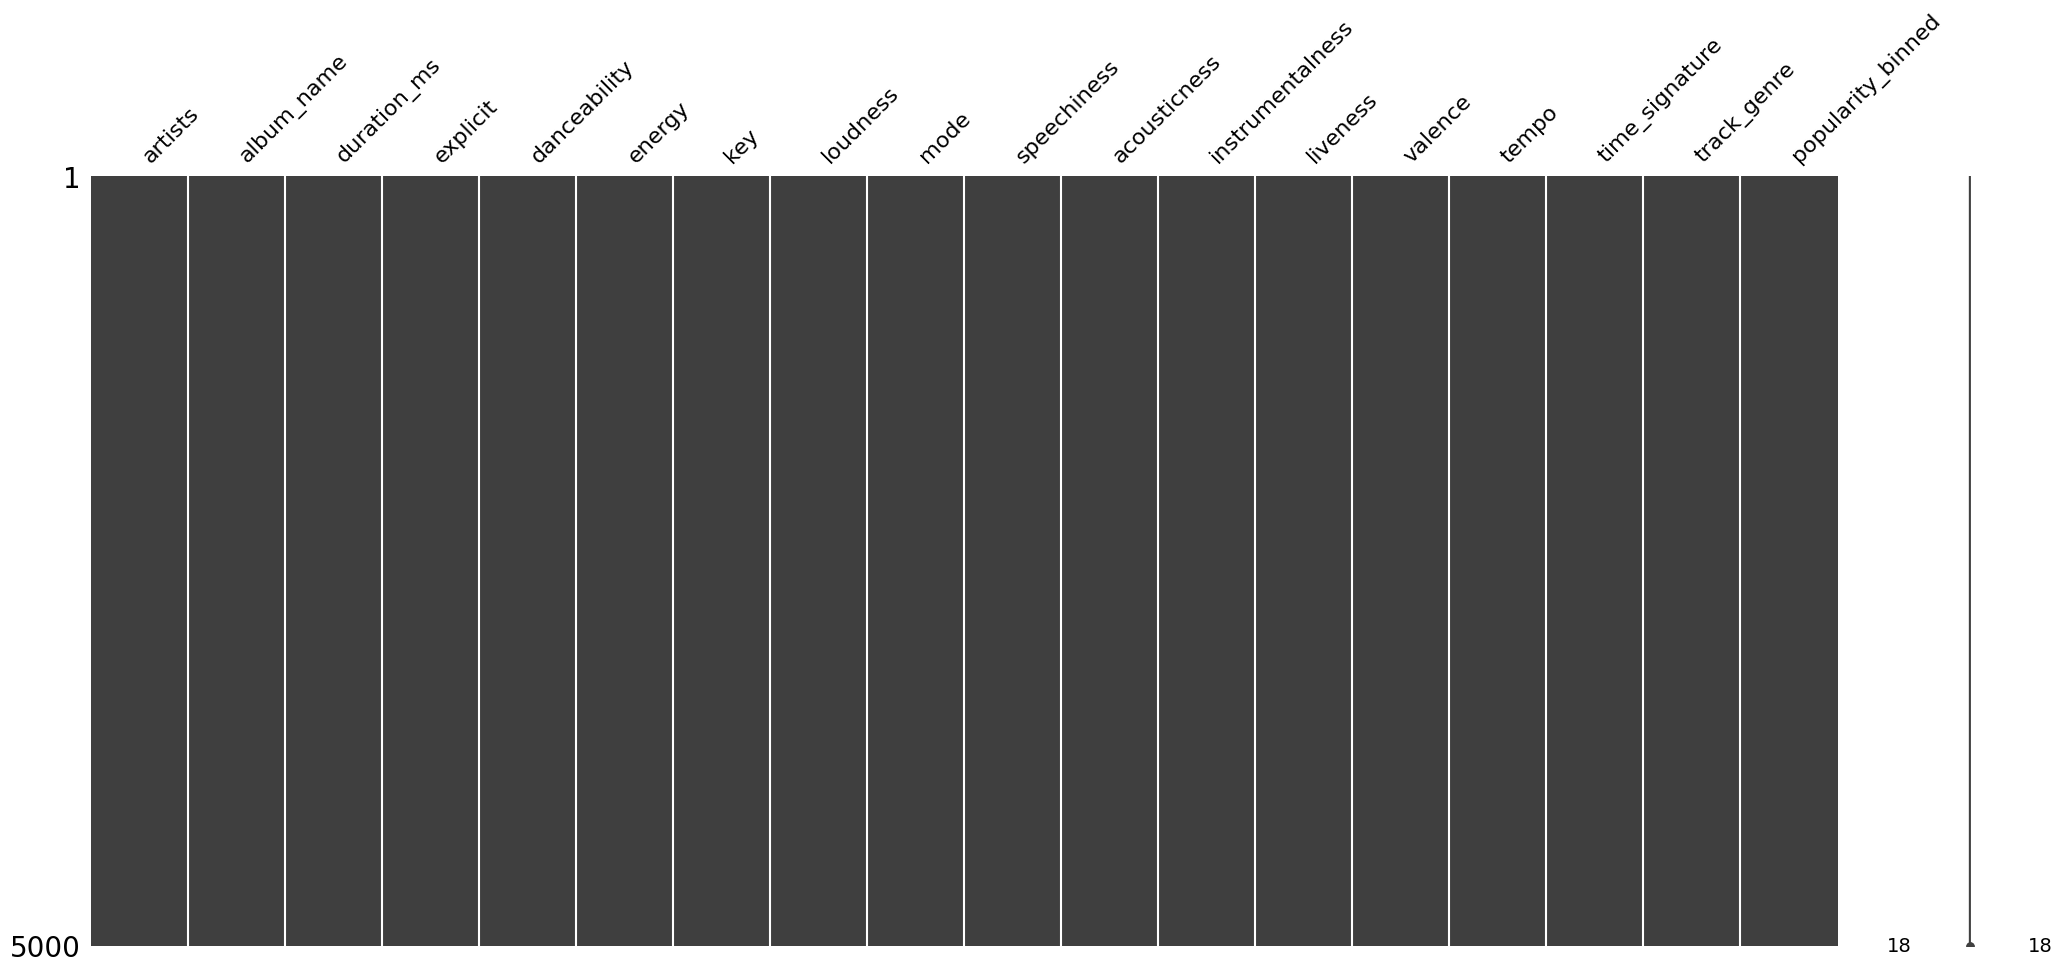

In [20]:
msno.matrix(dataset)

As seen, there are no features with missing values, so I intentionally add them to simulate real-world data flaws. This allows the model to be tested under more realistic conditions, ensuring it can handle incomplete data effectively and improving its robustness in practical applications.

Let's then proceed in order to be able to proceed with Data Transformation Pipeline:

In [21]:
# The following methods inserts a certain quantity of missing values into the column specify by the argument col
def add_missing(col, amount):
    X = col.copy()
    size = amount if amount >= 1 else int(len(X) * amount)
    indexes = np.random.choice(X.index, size, replace=False)  
    X.loc[indexes] = np.nan  
    return X

# The following method inserts a certain quantity of rows full of missing values at random position of the DataFrame. 
def add_missing_rows(df, amount):
    X = df.copy()
    rows, cols = X.shape
    size = amount if amount >= 1 else int(rows * amount)
    indexes = np.random.choice(rows, size, replace = False ) + 0.5
    for i in indexes:
        X.loc[i] = np.full((cols,),np.nan)
    X = X.sort_index().reset_index(drop=True)
    return X

In [22]:
dataset['key'] = add_missing(dataset['key'], 0.01)
dataset['duration_ms'] = add_missing(dataset['duration_ms'],0.02)
dataset['explicit'] = add_missing(dataset['explicit'], 0.05)
dataset['loudness'] = add_missing(dataset['loudness'],0.015)
dataset['liveness'] = add_missing(dataset['liveness'], 0.03)
dataset['acousticness'] = add_missing(dataset['acousticness'], 0.04)
dataset['mode'] = add_missing(dataset['mode'], 0.01)
dataset = add_missing_rows(dataset, 0.01)

Checking if the above code worked, using different methods implemented by Pandas:

In [23]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5050 entries, 0 to 5049
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   artists            5000 non-null   object 
 1   album_name         5000 non-null   object 
 2   duration_ms        4900 non-null   float64
 3   explicit           4750 non-null   object 
 4   danceability       5000 non-null   float64
 5   energy             5000 non-null   float64
 6   key                4950 non-null   float64
 7   loudness           4925 non-null   float64
 8   mode               4950 non-null   float64
 9   speechiness        5000 non-null   float64
 10  acousticness       4800 non-null   float64
 11  instrumentalness   5000 non-null   float64
 12  liveness           4850 non-null   float64
 13  valence            5000 non-null   float64
 14  tempo              5000 non-null   float64
 15  time_signature     5000 non-null   float64
 16  track_genre        5000 

From the above output, it is clear that the dataset has been changed: 

- many empty rows have been added (5050 entries vs. initial 5000)

- many features have now non-null values much less then the total number of rows

To visualize the same information in a different way, let's use the isnull()  method to check how many missing values each column contain.

In [24]:
dataset.isnull().sum(axis=0)

artists               50
album_name            50
duration_ms          150
explicit             300
danceability          50
energy                50
key                  100
loudness             125
mode                 100
speechiness           50
acousticness         250
instrumentalness      50
liveness             200
valence               50
tempo                 50
time_signature        50
track_genre           50
popularity_binned     50
dtype: int64

And the msno matrix:

<AxesSubplot: >

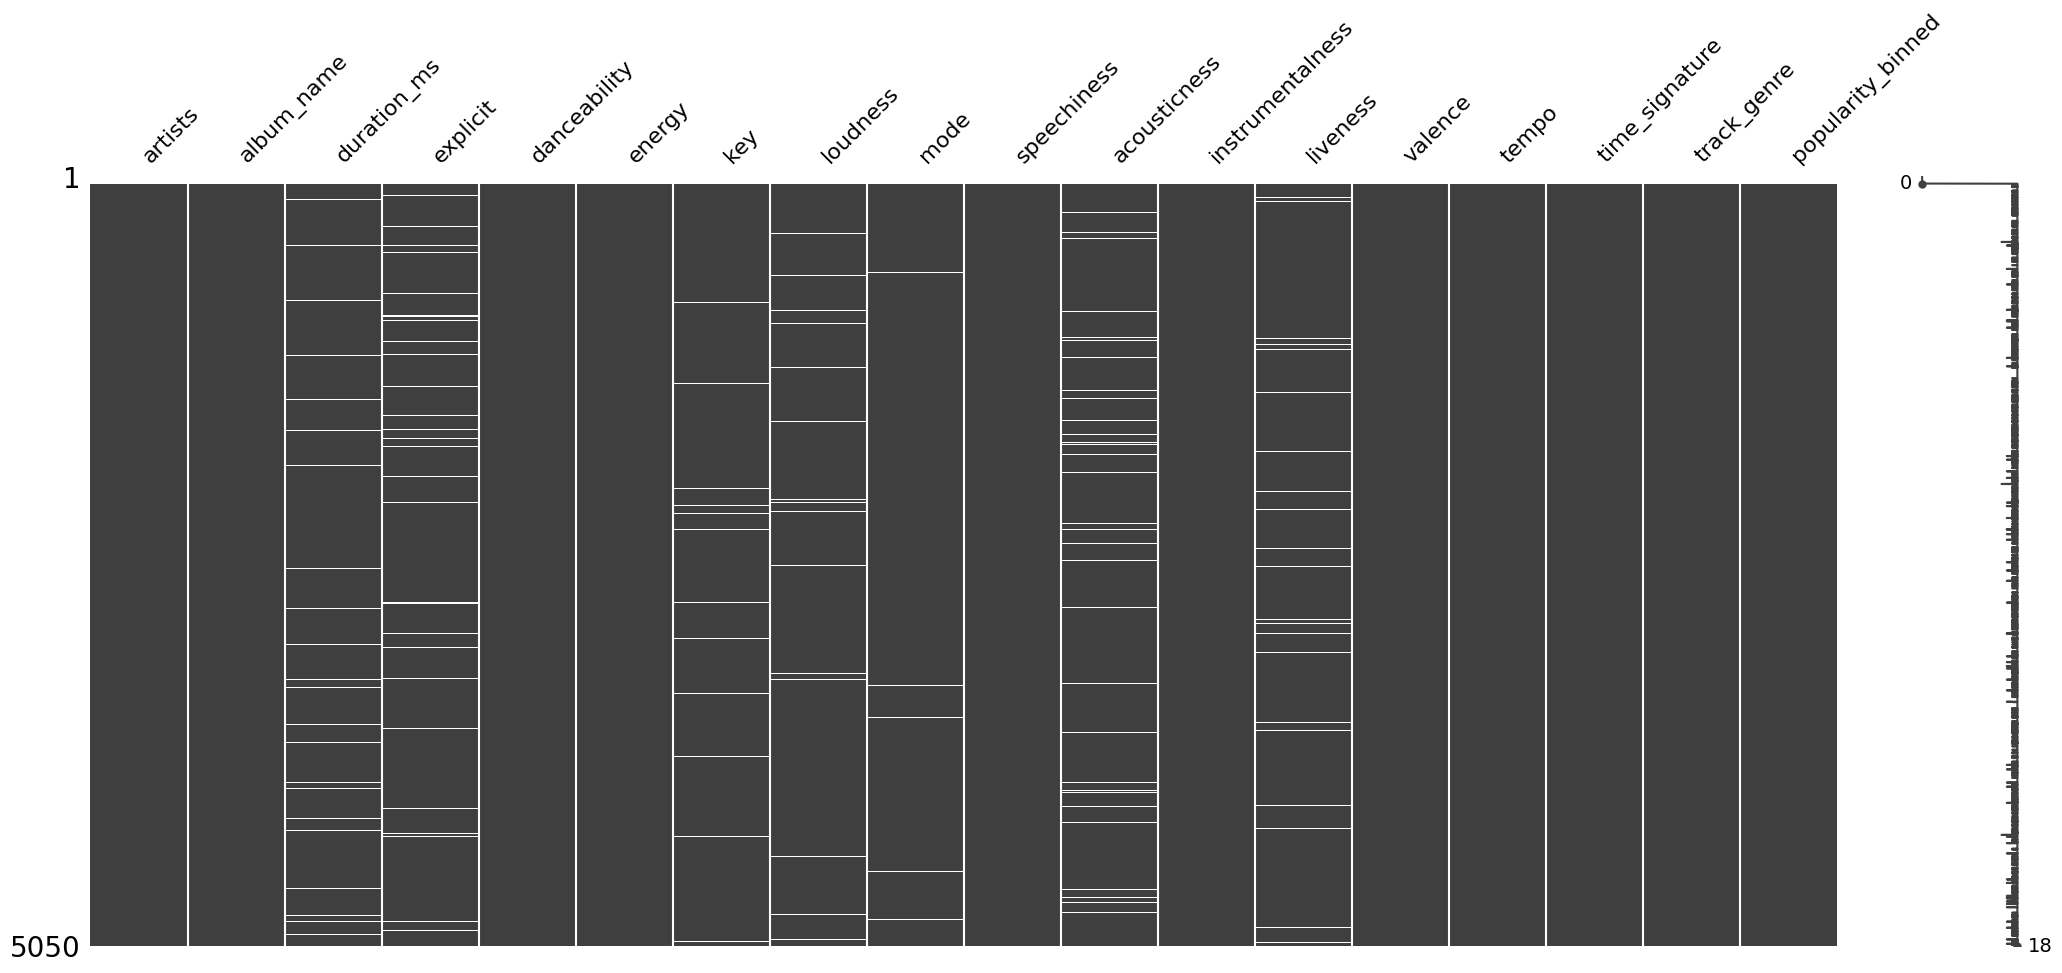

In [25]:
msno.matrix(dataset)

From the graph, I can guess there are some entire missing rows. 

Hence, I proceed with the elimination of the rows that have all missing values (= 18 = number of features = number of columns).

In [26]:
dataset = dataset.dropna(axis=0,how='all')

Let's check if it worked:

<AxesSubplot: >

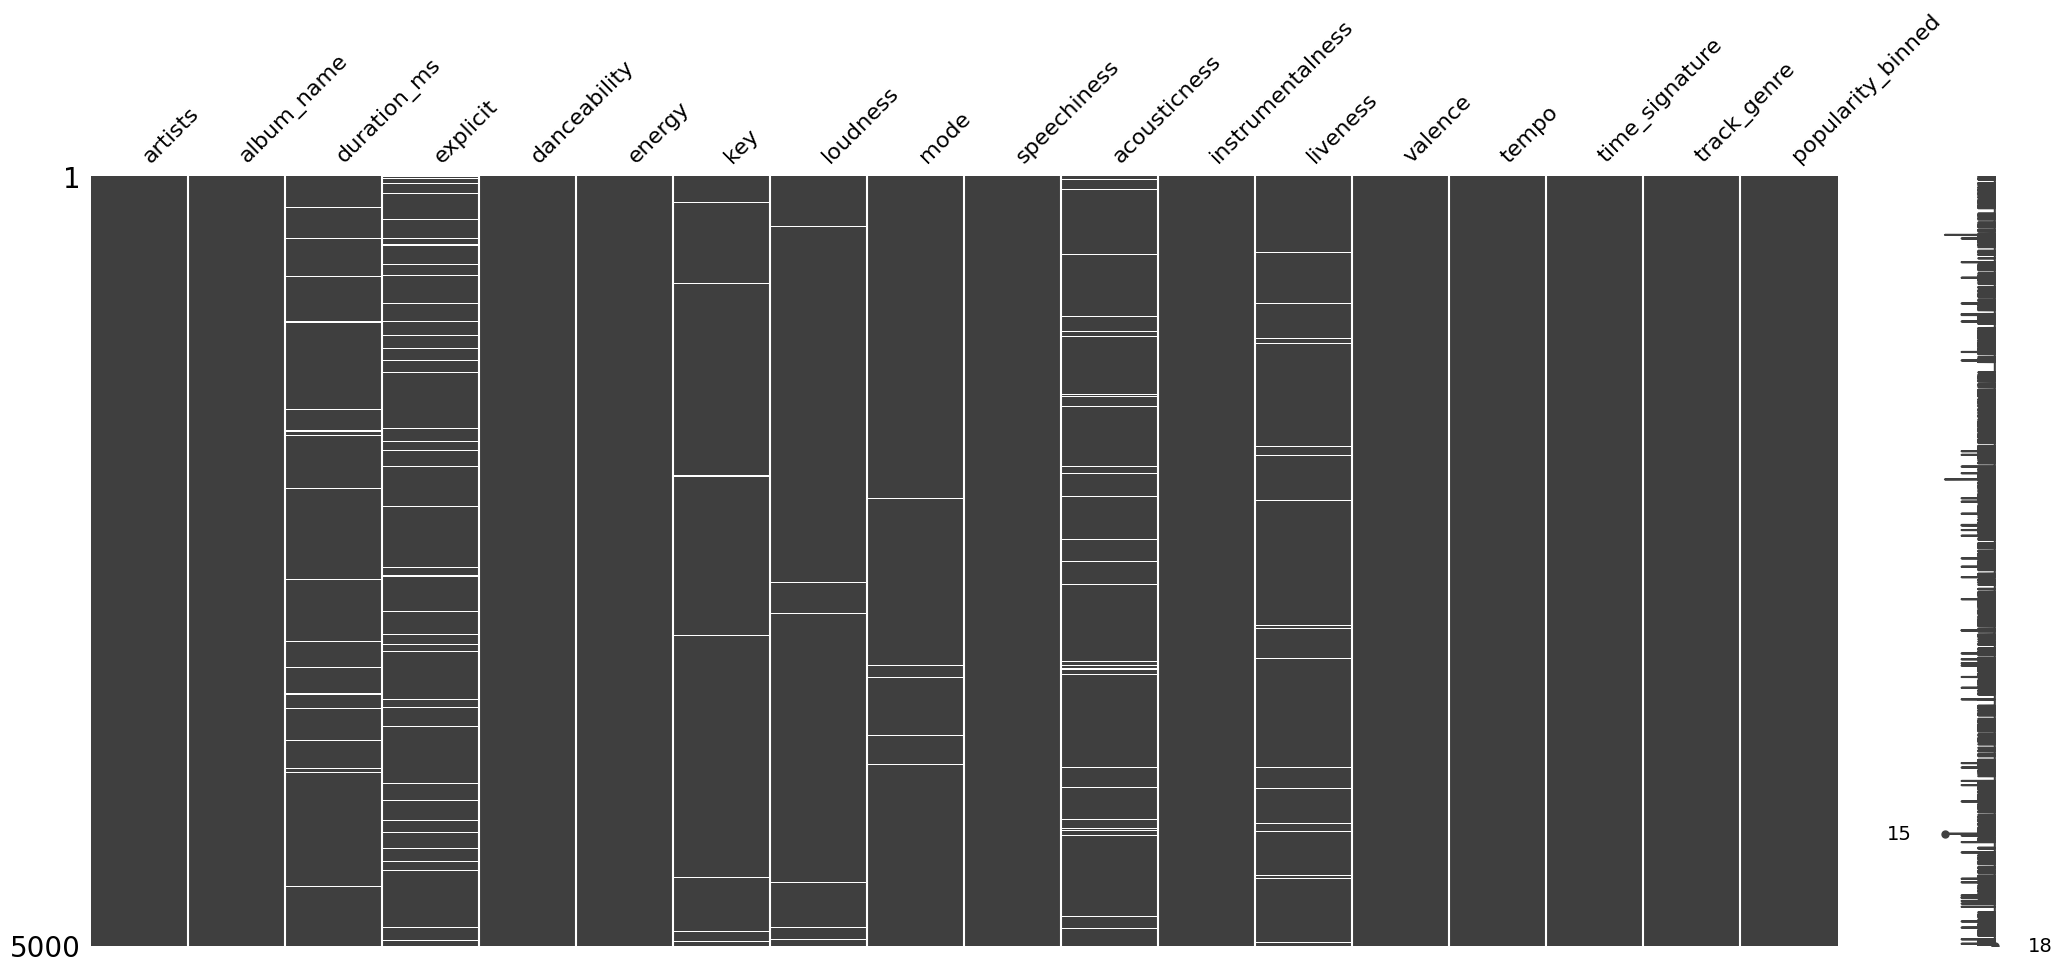

In [27]:
msno.matrix(dataset)

It worked: now I have 5000 entries (as the initial untouched dataset).

Let's now remove the rows which has more than 20% of missing values (i.e. more than about 4 missing values):

In [28]:
dataset = dataset.dropna(thresh=14, axis=0) 
# thresh = 14: I need at least 14 non-missing values in each row to keep the row
# axis = 0: meaning I am working with rows

In [29]:
dataset

,artists,album_name,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,popularity_binned
50,Chris Brown,Indigo (Extended),184613.0,True,0.733,0.690,9.0,-5.529,0.0,0.0427,0.06350,0.000001,0.1050,0.310,116.992,4.0,dance,2.0
51,Sam Smith;Kim Petras,Unholy (feat. Kim Petras),156943.0,False,0.714,0.472,2.0,-7.375,1.0,0.0864,0.01300,0.000005,0.2660,0.238,131.121,4.0,dance,2.0
52,Katy Perry,Harleys In Hawaii,185815.0,False,0.722,0.757,10.0,-6.207,0.0,0.1320,0.18500,0.000006,0.1260,0.721,140.094,4.0,dance,2.0
53,Sean Paul;Dua Lipa,Mad Love The Prequel,221176.0,NaN,0.742,0.882,7.0,-2.862,1.0,0.1170,0.04660,0.000000,0.2060,0.463,102.040,4.0,dance,2.0
54,The Chainsmokers;Halsey,Closer,244960.0,False,0.748,0.524,8.0,-5.599,1.0,0.0338,0.41400,0.000000,0.1110,0.661,95.010,4.0,dance,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5045,Melike Şahin,Merhem: İlk Konserler (Live),269354.0,False,0.551,0.478,10.0,-10.580,0.0,0.0378,0.52600,0.000000,0.2880,0.523,98.056,4.0,singer-songwriter,1.0
5046,Barış Kocatürk,Kesin Kesiktir,199285.0,False,0.646,0.645,11.0,-6.775,0.0,0.0287,0.24600,0.000000,0.1810,0.687,121.999,4.0,singer-songwriter,1.0
5047,Nina Nesbitt,"The Sun Will Come up, The Seasons Will Change",176853.0,NaN,0.690,0.582,5.0,-6.259,0.0,0.0333,0.35800,0.000000,0.0776,0.448,122.020,4.0,singer-songwriter,1.0
5048,Joe Walsh,(70's) Seventies Collected Volume 2,316066.0,False,0.449,0.571,4.0,-7.119,1.0,0.0492,0.00604,0.701000,0.0748,0.448,84.807,4.0,singer-songwriter,0.0


As the number of rows didn't change (it is still 5000), there are no rows that have more than 20% of missing values.

Let's continue considering the columns. To check the percentage of missing values in each column:

In [30]:
dataset.isnull().sum(axis=0)/dataset.shape[0]

artists              0.000
album_name           0.000
duration_ms          0.020
explicit             0.050
danceability         0.000
energy               0.000
key                  0.010
loudness             0.015
mode                 0.010
speechiness          0.000
acousticness         0.040
instrumentalness     0.000
liveness             0.030
valence              0.000
tempo                0.000
time_signature       0.000
track_genre          0.000
popularity_binned    0.000
dtype: float64

As the percentage of missing values is quite low for every single column, I don't want to drop any of them. 

# Data Transformation

After having identified the features to discard, the next step is to define — but not yet apply — the data transformation pipeline. This involves specifying the transformations to be applied to each feature.

In this case, the pipeline will stick to the following pattern:

<img src="transformation-pipeline.jpeg" width="" align="" />

For features duration_ms, key, mode and time_signature the pipeline:

1.  SimpleImputer:  features duration_ms, key and mode contain missing values, while the other columns will be untouched. As strategy. I use 'most_frequent' since all features are numerical and discrete (it substitutes missing values with the most frequent in the column).

2.   StandardScaler:  for all features above-mentioned, as they're numerical (I normalize the features so that they have mean = 0 and std = 1).

On the other hand, features liveliness, loudness, acousticness, danceability valence, energy, speechiness, tempo and instrumentalness, the situation is slightly different:

1.  SimpleImputer: features liveliness, loudness and acousticness contain missing values, while the other column will be untouched. Since I'm now dealing with numerical continuous features, as strategy I use 'mean' (it substitutes missing values with the mean of the column).

2.   StandardScaler:  for all features above-mentioned, as they're numerical (I normalize the features so that they have mean = 0 and std = 1).

Regarding, instead, features explicit and track_genre, which are categorical nominal, I will use: 

1.  SimpleImputer: explicit contains missing values, the other will be untouched. As strategy I use, again, 'most_frequent'.

2.   One Hot Encoder because features are categorical and they must be transformed into a numerical representation (each value of the feature into a binary column).

Lastly, for features artists and album_name, which are textual and does not contain missing values , the pipeline is composed by:

2.   TfidVectoriuizer: transforms the columns in a set of unique terms and calculate the importance of each term with respect to the whole.

In [31]:
# Continuous numerical features
numeric_discrete_missing = ['duration_ms', 'key', 'mode']
numeric_discrete = ['time_signature']

# Discrete numerical features
numeric_continuous_missing = ['liveness', 'loudness', 'acousticness']
numeric_continuous = ['danceability', 'valence', 'energy', 'speechiness', 'tempo', 'instrumentalness']

# Categorical nominal features 
categorical_missing = ['explicit']
categorical = ['track_genre']

# Textual variables:
textual = ['artists', 'album_name']

In [32]:
# Pre-imputation outside the pipeline to ensure that the column transformer can insert the column name as a string without creating problems for TfidVectorizer
for col in textual:
    dataset[col] = dataset[col].fillna("unknown").astype(str)

## Pipelines

In [33]:
# Pipeline for numerical continuous features
numCont_transformer_missing = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('scaler', StandardScaler())                 
])
numCont_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Pipeline for numerical discrete features
numDiscr_transformer_missing = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  
    ('scaler', StandardScaler())                 
])
numDiscr_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Pipeline for categorical nominal features
categorical_transformer_missing = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('onehot', OneHotEncoder(categories='auto', drop='first', handle_unknown='ignore'))     
])
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(categories='auto', drop='first', handle_unknown='ignore'))     
])

# Configuration of TfodVectorizer for textual features:
artist_vectorizer = TfidfVectorizer(max_features=100, ngram_range=(1, 5), min_df=3)
album_name_vectorizer = TfidfVectorizer(max_features=100, ngram_range=(1, 5), min_df=3)

## Column Transformer

To make sure that both numerical and categorical features are processed correctly, I now put the defined pipelines within a single structure.

In [34]:
# Combining the different transformations:
preprocessor = ColumnTransformer(
    transformers=[
        ('num_cont', numCont_transformer, numeric_continuous),     
        ('num_cont_missing', numCont_transformer_missing, numeric_continuous_missing),
        ('num_discr', numDiscr_transformer, numeric_discrete),     
        ('num_discr_missing', numDiscr_transformer_missing, numeric_discrete_missing),  
        ('cat', categorical_transformer, categorical),
        ('cat_missing', categorical_transformer_missing, categorical_missing),         
        ('artists', artist_vectorizer,'artists'),
        ('album_name', album_name_vectorizer,'album_name'),
    ],
    remainder='drop', 
    verbose_feature_names_out=False,
    sparse_threshold=0
)

# Training and Test sets

Now, I can split the entire dataset into training and test sets, putting 20% of the instances in the test set (note that I'll be using the test set only at the end of the model selection process).

In order to predict the popularity of a song, let's divide the dataset as the following:

In [35]:
# Separation of the features (X) and the target (y)
X = dataset.drop(columns=['popularity_binned'])  # all columns except 'popularity_binned'
y = dataset['popularity_binned']  # the target column

In [36]:
# Division of the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y,random_state=30, shuffle=True
)

Underlining that:

- stratify=y prevents imbalance making sur that the class distribution remains the same in both sets

- random_state=30 guarantees reliability of the split

- shuffle=True : shuffles the data at random before splitting to ensure a fair distribution

# Model Selection

Model Selection is the process of finding the models with the highest performance, guaranteeing a good generalization on unseen data (avoiding, consequentially, both overfitting and underfitting).

I'll do this through nested cross-validation process which combines hyperparameter optimization and model evaluation.

By defining the model, I mean defining a pipeline which contains:

- data transformation

- handling imbalanced classes

- dimensionality reduction

- classification

Let's then proceed and define a starting model pipeline.

In [37]:
model_pipeline = IMBPipeline([
    ('trans', preprocessor),
    ('sampler', SMOTE(k_neighbors=3)),
    ('dim_reduction', PCA(n_components=0.8)),
    ('classifier', Perceptron())
])

Just to be sure that no errors are occurring, let's run a fit on the training set and predict on the test set.

In [38]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('trans',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('num_cont',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['danceability', 'valence',
                                                   'energy', 'speechiness',
                                                   'tempo',
                                                   'instrumentalness']),
                                                 ('num_cont_missing',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['liveness', 'loudnes...
                                                                                 handle_unknown='ignore'))]),
                                                  ['explicit']),
                                                 ('artists',
                                                  TfidfVectorizer(max_features=100,
                                                                  min_df=3,
                                                                  ngram_range=(1,
                                                                               5)),
                                                  'artists'),
                                                 ('album_name',
                                                  TfidfVectorizer(max_features=100,
                                                                  min_df=3,
                                                                  ngram_range=(1,
                                                                               5)),
                                                  'album_name')],
                                   verbose_feature_names_out=False)),
                ('sampler', SMOTE(k_neighbors=3)),
                ('dim_reduction', PCA(n_components=0.8)),
                ('classifier', Perceptron())])

In [39]:
model_pipeline.predict(X_test)

array([2., 0., 0., 2., 2., 2., 1., 2., 0., 1., 1., 0., 0., 1., 1., 0., 0.,
       1., 0., 1., 0., 1., 1., 2., 0., 2., 0., 2., 1., 0., 1., 2., 2., 0.,
       0., 0., 0., 2., 1., 0., 1., 2., 1., 0., 0., 2., 1., 0., 2., 0., 0.,
       1., 0., 0., 0., 2., 1., 1., 2., 1., 2., 1., 0., 0., 1., 0., 1., 1.,
       2., 2., 0., 0., 0., 0., 0., 1., 0., 0., 2., 1., 0., 2., 0., 1., 1.,
       0., 1., 0., 2., 2., 0., 2., 0., 2., 2., 2., 1., 2., 1., 2., 0., 0.,
       2., 2., 1., 1., 0., 0., 2., 2., 2., 1., 0., 0., 1., 2., 0., 0., 1.,
       0., 1., 1., 2., 0., 0., 0., 1., 0., 2., 2., 1., 2., 2., 0., 1., 2.,
       1., 1., 2., 1., 1., 0., 1., 2., 1., 0., 1., 0., 2., 1., 0., 2., 2.,
       2., 0., 1., 1., 1., 0., 0., 2., 0., 0., 2., 0., 1., 2., 1., 2., 1.,
       0., 1., 1., 0., 0., 2., 0., 0., 1., 1., 2., 0., 2., 1., 2., 1., 1.,
       1., 1., 0., 0., 0., 0., 1., 2., 1., 1., 1., 1., 0., 1., 1., 2., 1.,
       1., 2., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 2., 0., 2., 0., 2.,
       2., 0., 1., 0., 1.

All the elements seem to be distinct, let's then continue with the definition of the possibile configurations of the hyperparameters I'm going to use during the hyperparameter tuning of the model selection.

## Hyperparameter Optimization and Model Evaluation

Strategies to make sure that the model does not become biased toward the majority class (therefore, ensuring a balanced class distribution):

In [40]:
sampler_configs = [
    {
        'sampler': [None], 
    },
    {
        'sampler':[SMOTE(n_jobs=-1)],
        'sampler__sampling_strategy':[0.3, 0.5]
    },
    {
        'sampler':[RandomOverSampler()],
        'sampler__sampling_strategy': [0.3, 0.5]
    }
]

Strategies to refine computational complexity and reduce the risk of overfitting.

In [41]:
dim_reduction_configs = [
    {
        'dim_reduction': [None]  
    },
    {
        'dim_reduction': [PCA()],
        'dim_reduction__n_components': [0.5, 0.7]
    },
    {
        'dim_reduction': [LDA()]  
    }
]

Possible classifiers that can be efficient for multi-class classification tasks, and their respective feasibile hyperparameters.

In [42]:
classifier_configs = [
    {
        'classifier': [LogisticRegression(multi_class = 'multinomial', solver='saga')],
        'classifier__C': loguniform(0.001, 1),
        'classifier__penalty': ['l1', 'l2'],
        'classifier__class_weight': [None, 'balanced']
    },
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [5, 7, 9]
    },
    {
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [3, 5, 7],
        'classifier__min_samples_leaf': [2, 5]
    },
    {
        'classifier': [GradientBoostingClassifier()],
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.01, 0.03],
        'classifier__max_depth': [3, 5]
    },
    {
        'classifier': [AdaBoostClassifier()],
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.05, 0.1]
    }
]

In [43]:
import itertools

all_configs = [dict(itertools.chain(*(e.items() 
for e in configuration))) 
for configuration in 
itertools.product(sampler_configs,dim_reduction_configs,classifier_configs)]

Sanity check to make sure configurations of the hypothetical models are correctly defined:

In [44]:
all_configs[:5]

[{'sampler': [None],
  'dim_reduction': [None],
  'classifier': [LogisticRegression(multi_class='multinomial', solver='saga')],
  'classifier__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7fd91a48cd00>,
  'classifier__penalty': ['l1', 'l2'],
  'classifier__class_weight': [None, 'balanced']},
 {'sampler': [None],
  'dim_reduction': [None],
  'classifier': [KNeighborsClassifier()],
  'classifier__n_neighbors': [5, 7, 9]},
 {'sampler': [None],
  'dim_reduction': [None],
  'classifier': [RandomForestClassifier()],
  'classifier__n_estimators': [100, 200],
  'classifier__max_depth': [3, 5, 7],
  'classifier__min_samples_leaf': [2, 5]},
 {'sampler': [None],
  'dim_reduction': [None],
  'classifier': [GradientBoostingClassifier()],
  'classifier__n_estimators': [100, 200],
  'classifier__learning_rate': [0.01, 0.03],
  'classifier__max_depth': [3, 5]},
 {'sampler': [None],
  'dim_reduction': [None],
  'classifier': [AdaBoostClassifier()],
  'classifier__n_estimators': [100

In [45]:
f'Number of all possible configurations: {len(all_configs)}'

'Number of all possible configurations: 45'

Now, we can use nested-cross validation to identify 5 different best candidates to be our reference model.

First, we have to define the RandomizedSearchCV object which implement the inner loop: I use the method StratifiedKfold() in order to guarantee that classes distribution in each fold is proportional to the one of the entire vector.

In [46]:
# Outer loop for model evaluation
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Inner loop for hyperparameter optimization
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [47]:
rs = RandomizedSearchCV(model_pipeline,
    param_distributions=all_configs,
    n_iter=len(all_configs)*5,
    n_jobs=-1,  
    cv=inner_cv, 
    scoring='f1_weighted'
)

In [48]:
scores = cross_validate(
    rs,
    X_train, y_train,
    scoring='f1_weighted',
    cv=outer_cv,
    return_estimator=True,
    verbose=3,
    error_score='raise'
)

[CV] END ......................................., score=0.803 total time=10.4min
[CV] END ......................................., score=0.764 total time=11.6min
[CV] END ......................................., score=0.795 total time=13.8min
[CV] END ......................................., score=0.793 total time=12.3min
[CV] END ......................................., score=0.774 total time=14.3min


The output returned by cross_validate is a dictionary containing the information of each cross-validation iteration:

1. best estimator given by the randomized grid search

2. hyperparameters of the best estimators

3. the best estimator's score (f1_ weighted in this case) in the validation fold 

In this case, the execution time varies slightly between folds, indicating good efficiency of the model and training pipeline.

Moreover, results suggest that the model has generalized well, maintaining consistent performance across different data subsets.

In [49]:
for index, estimator in enumerate(scores['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores['test_score'][index])
    print('-'*10)

None
LinearDiscriminantAnalysis()
LogisticRegression(C=0.08100068956415321, class_weight='balanced',
                   multi_class='multinomial', solver='saga') {'C': 0.08100068956415321, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'multinomial', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
0.803321575774226
----------
None
LinearDiscriminantAnalysis()
RandomForestClassifier(max_depth=7, min_samples_leaf=5, n_estimators=200) {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 7, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
0.7638

To have an even clearer idea of ​​the best model to choose, let's re-train the above-resultant models on the entire training set and evaluate their performance on the test set. 

In [50]:
for estimator in scores['estimator']:
    pred_train = estimator.best_estimator_.fit(X_train, y_train)
    pred_train = estimator.best_estimator_.predict(X_train)
    pred_test = estimator.best_estimator_.predict(X_test)
    f1_train = f1_score(y_train, pred_train, average='weighted')
    f1_test = f1_score(y_test, pred_test, average='weighted')
    print(f'F1 on training set:{f1_train}, F1 on test set:{f1_test}')

F1 on training set:0.8070916609491027, F1 on test set:0.7874657493193762
F1 on training set:0.8337470410329225, F1 on test set:0.7900790672177933
F1 on training set:0.8067759323594045, F1 on test set:0.7883748860594526
F1 on training set:0.8195611510642089, F1 on test set:0.7895046718828322
F1 on training set:0.8095031820549798, F1 on test set:0.803434525044366


Again, these scores indicate that the models are well-generalized, with only a slight drop in performance from the training set to the test set, which is a good sign of minimal overfitting.

The close alignment between the training and test F1-scores further supports that the chosen models are robust and reliable for predicting the popularity of new songs on Spotify. 

## Refinement of the selected model

From the previous analysis, I notice that a model that is always chosen as best  - at least in one of the folds -  is Linear Regression with no sampling strategy and LDA as dimensionality reduction, suggesting that this combination is quite efficient in order to "win".

Let's then proceed with the refinement of the above-mentioned selected model, finding the optimanl parameters to have the best performances.

In [56]:
best_model_pipeline = IMBPipeline([
    ('preprocessor', preprocessor),
    ('dim_reduction', LDA()),
    ('classifier', LogisticRegression(multi_class='multinomial', solver='saga'))
])

In [58]:
param_dist = {
    'classifier__C': loguniform(0.001, 10),
    'classifier__penalty': ['l1', 'l2', 'none'],
    'classifier__class_weight': [None, 'balanced']
}

In [53]:
# Here I use RepeatedStratifiedKFold to repeat k-folds many times and return the average performance 
rs_best = RandomizedSearchCV(
    estimator=best_model_pipeline, 
    param_distributions=param_dist, 
    n_iter=20, 
    cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=1), 
    scoring='f1_weighted'
)

In [60]:
rs_best.fit(X_train, y_train)

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=5, random_state=None),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(sparse_threshold=0,
                                                                transformers=[('num_cont',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['danceability',
                                                                                'valence',
                                                                                'energy',
                                                                                'speechiness',
                                                                                'tempo',
                                                                                'instrumentalness']),
                                                                              ('num_cont_missing',
                                                                               Pipeline(step...
                                                                               'album_name')],
                                                                verbose_feature_names_out=False)),
                                             ('classifier',
                                              LogisticRegression(multi_class='multinomial',
                                                                 solver='saga'))]),
                   n_iter=20,
                   param_distributions={'classifier__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fd91b51acd0>,
                                        'classifier__class_weight': [None,
                                                                     'balanced'],
                                        'classifier__penalty': ['l1', 'l2',
                                                                'none']},
                   scoring='f1_weighted')

In [61]:
rs_best.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('num_cont',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['danceability', 'valence',
                                                   'energy', 'speechiness',
                                                   'tempo',
                                                   'instrumentalness']),
                                                 ('num_cont_missing',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['liveness', '...
                                                                                 handle_unknown='ignore'))]),
                                                  ['explicit']),
                                                 ('artists',
                                                  TfidfVectorizer(max_features=100,
                                                                  min_df=3,
                                                                  ngram_range=(1,
                                                                               5)),
                                                  'artists'),
                                                 ('album_name',
                                                  TfidfVectorizer(max_features=100,
                                                                  min_df=3,
                                                                  ngram_range=(1,
                                                                               5)),
                                                  'album_name')],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 LogisticRegression(C=7.505412766856048,
                                    multi_class='multinomial', penalty='none',
                                    solver='saga'))])

In [62]:
print('Best Params:', rs_best.best_params_)
y_pred = rs_best.predict(X_test)
print('F1-score (weighted):', f1_score(y_test, y_pred, average='weighted'))

Best Params: {'classifier__C': 7.505412766856048, 'classifier__class_weight': None, 'classifier__penalty': 'none'}
F1-score (weighted): 0.8023406079612289


In [63]:
cls = rs_best.best_estimator_

### Learning Curve

The learning curve indicates how the model's performance changes as the size of the training set increases. It helps identify if the model suffers from overfitting (performing well on training but poorly on validation) or underfitting (performing poorly on both).

In [65]:
train_sizes, train_scores, test_scores = learning_curve(cls, 
                                                        X_train, 
                                                        y_train, 
                                                        train_sizes= [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
                                                        cv=5, 
                                                        scoring='f1_weighted',
                                                        shuffle=False)

print("Train sizes:", train_sizes)
print("Train scores mean:", np.mean(train_scores, axis=1))
print("Test scores mean:", np.mean(test_scores, axis=1))

Train sizes: [  32  320  640  960 1280 1600 1920 2240 2560 2880 3200]
Train scores mean: [       nan 0.87149854 0.84763518 0.82747125 0.82622183 0.81705151
 0.82423716 0.81777793 0.81579814 0.81605699 0.81459223]
Test scores mean: [       nan 0.71940045 0.76912159 0.76569695 0.77093046 0.77417567
 0.77770616 0.78102686 0.7826782  0.78719138 0.78668029]


(0.6, 1.03)

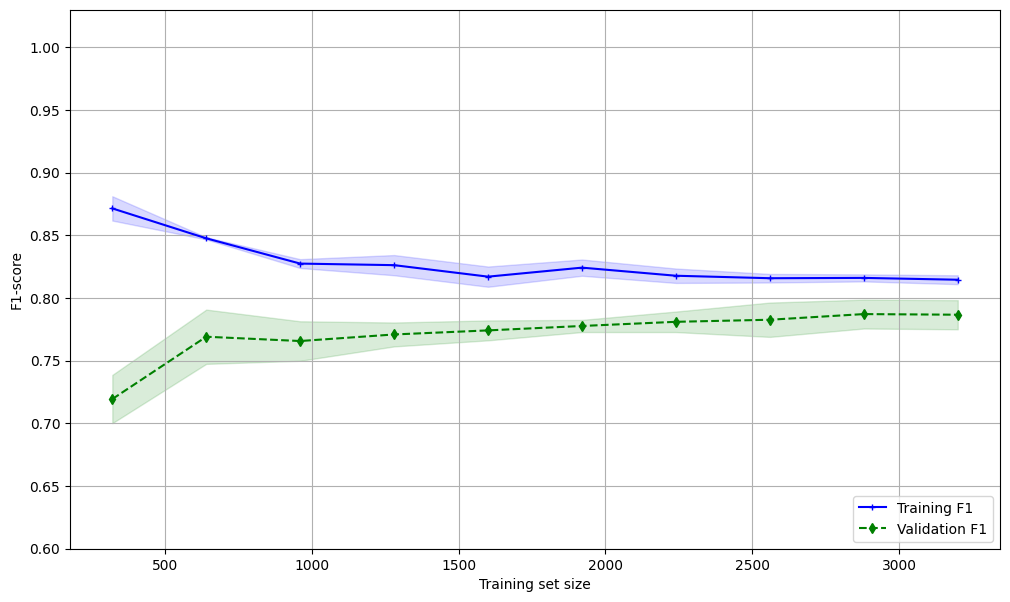

In [66]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()

ax.plot(train_sizes, train_mean,
         color='blue', marker='+',
         markersize=5, label='Training F1')

ax.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='d', markersize=5,
         label='Validation F1')

ax.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Training set size')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
ax.set_ylim([0.60, 1.03])

### Validation Curve

The validation curve illustrates the model’s performance across different values of a hyperparameter (in this case, the regularization parameter C). It helps select the best hyperparameter value by balancing bias and variance.

In [76]:
range_C = [0.000001, 0.0001, 0.001,0.01,0.1,1,10,100, 10000]
train_scores, test_scores = validation_curve(cls,
        X=X_train, 
        y=y_train, 
        param_range=
        range_C, 
        param_name='classifier__C',
        cv=5, 
        n_jobs=-1, 
        scoring='f1_weighted'
)

(1e-06, 1000)

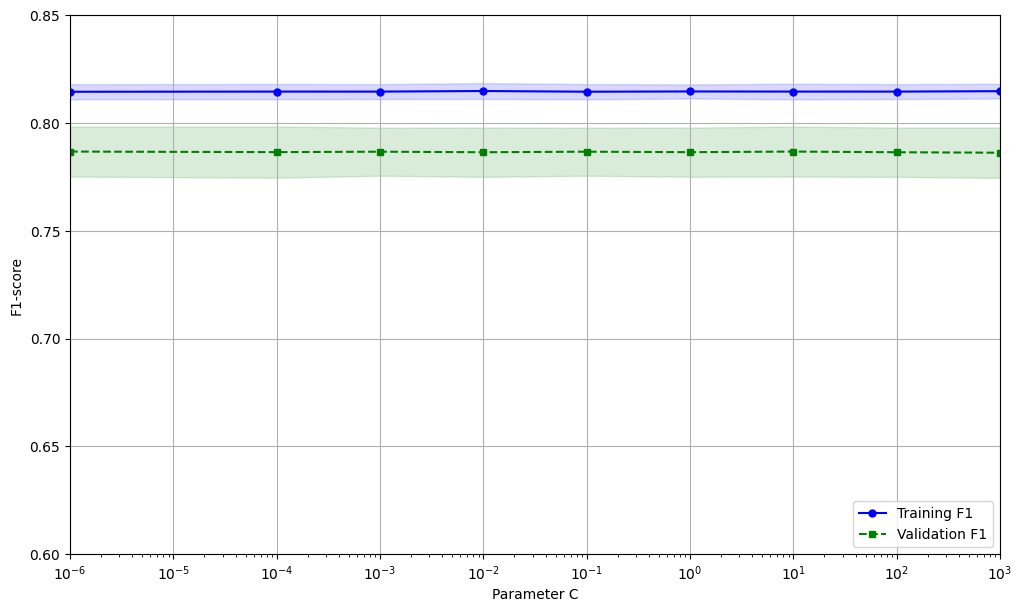

In [77]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()
ax.plot(range_C, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training F1')

ax.fill_between(range_C,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(range_C, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation F1')

ax.fill_between(range_C,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Parameter C')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
ax.set_ylim([0.6, 0.85])
ax.set_xscale('log')
ax.set_xlim([0.000001,1000])

### ROC Curve

The ROC curve (Receiver Operating Characteristic) evaluates the model's ability to distinguish between classes at various threshold settings. The area under the curve (AUC) measures the overall performance: higher AUC values indicate better performance.

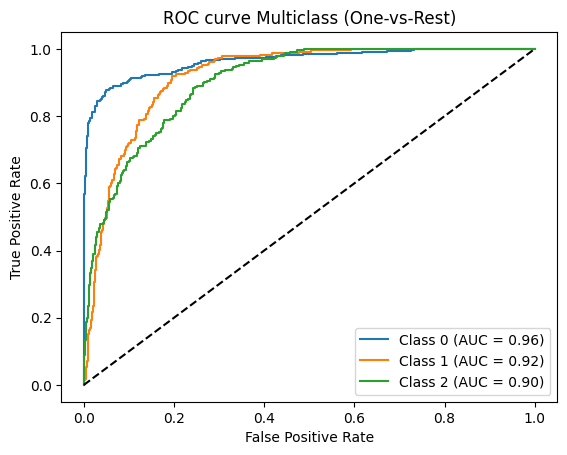

In [69]:
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_binarized.shape[1]

# obtain predicted probabilities by the model
y_score = cls.predict_proba(X_test)

# compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# plot of ROC curve for each class
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve Multiclass (One-vs-Rest)')
plt.legend(loc='best')
plt.show()


Class 0 (AUC = 0.96):
The curve for class 0 is very close to the top left corner, indicating excellent discriminative abilities, suggesting, again that the model is very effective in distinguishing songs belonging to class 0 from others (low popularity).

Class 1 (AUC = 0.92):
Class 1 also has a good area under the curve, equal to 0.92, still showing a high ability to correctly recognize class 1 songs (medium popularity).

Classe 2 (AUC = 0.89):
Class 2 has the lowest AUC (0.89), meaning that, probably, the model has more difficulty distinguishing this class from the other two. However, a value of 0.89 is still considered very good (high popularity).

### Confusion Matrix

The confusion matrix displays the number of correct and incorrect predictions for each class, helping to understand which classes are well predicted and where errors occur.

It provides deeper insights, helping to calculate metrics such as Error, Precision, Recall and Accuracy, essential for evaluating model reliability, especially in imbalanced datasets.

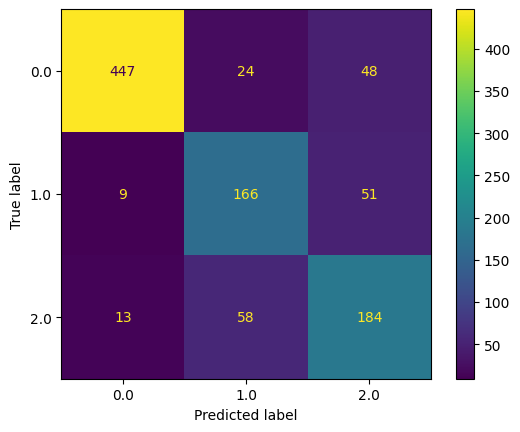

In [70]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cls.classes_)
disp.plot(cmap='viridis')

From the matrix, I can then compute the above-mentioned metrics:

- Accuracy:  (TP + TN) / (TP + TN + FP + FN) = 0.777    (77.7%)

- Error Rate:   (FP + FN) / (TP + TN + FP + FN) = 0.223   (22.3%) 

- Precision:   TP / (TP + FP) =   

 0.811  (81.1% - class 0)

0.748  (74.8% - class 1)

0.733  (73.3% - class 2)

Ultimately, the model has a strong ability to correctly predict the 0 class, while there are more difficulties in separating the 1 and 2 classes, suggesting that further optimizations or targeted feature engineering.

# Conclusion

The analysis of the final selecteThe validation curve for the C parameter remains flat across the tested range, suggesting that the model is stable and not highly sensitive to regularization, which indicates a good generalization capability.d model, a multinomial Logistic Regression, shows consistent and satisfactory results demonstrating robustness and consistency.

The learning curve indicates that the model benefited from an increase in training data: the validation F1-score improved as more data was provided, stabilizing around an acceptable value close to 0.78, while the training F1-score remains close to 0.82. This indicates that the model benefits from additional data without significant overfitting.

The validation curve for the C parameter remains flat across the tested range, suggesting that the model is stable and not highly sensitive to regularization, which indicates a good generalization capability.

Additionally, the ROC curve for the multiclass classification shows high AUC values for all classes (0.96, 0.92, and 0.89), indicating strong discriminatory power across all categories.

Finally, the confusion matrix reveals that the model correctly classifies most songs into their respective popularity categories: the model has a strong ability to correctly predict the 0 class, while there are more difficulties in separating the 1 and 2 classes, suggesting that further optimizations or targeted feature engineering could improve the model.

In conclusion, the selected model has proven effective in predicting the popularity of new songs on Spotify, with potential improvements achievable through additional features or more complex models.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2fe84920-5afa-47e0-b4c3-5fc91580c6f4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>